In [1]:
import torch
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [2]:
import kagglehub

# Download latest version
path=kagglehub.dataset_download("dschettler8845/brats-2021-task1")

print("Path to dataset files:",path)

Using Colab cache for faster access to the 'brats-2021-task1' dataset.
Path to dataset files: /kaggle/input/brats-2021-task1


In [3]:
!mv /kaggle/input/brats-2021-task1 /content

mv: cannot remove '/kaggle/input/brats-2021-task1/BraTS2021_00495.tar': Read-only file system
mv: cannot remove '/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar': Read-only file system
mv: cannot remove '/kaggle/input/brats-2021-task1/BraTS2021_00621.tar': Read-only file system


In [4]:
!mkdir /content/Train_Data

In [5]:
!tar -xf /content/brats-2021-task1/BraTS2021_Training_Data.tar -C /content/Train_Data

In [6]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet,self).__init__()

    self.pool=nn.MaxPool2d(2,2)

    self.down1=nn.Sequential(
        nn.Conv2d(4,64,kernel_size=3,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
    )

    self.down2=nn.Sequential(
        nn.Conv2d(64,128,kernel_size=3,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
    )

    self.down3=nn.Sequential(
        nn.Conv2d(128,256,kernel_size=3,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
    )

    self.down4=nn.Sequential(
        nn.Conv2d(256,512,kernel_size=3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
    )

    self.bottle=nn.Sequential(
        nn.Conv2d(512,1024,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(1024,1024,kernel_size=3,padding=1),
        nn.ReLU()
    )

    self.up1=nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
    self.up_conv1= nn.Sequential(
        nn.Conv2d(1024,512,kernel_size=3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    self.up2= nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
    self.up_conv2= nn.Sequential(
        nn.Conv2d(512,256,kernel_size=3,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.up3= nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
    self.up_conv3= nn.Sequential(
        nn.Conv2d(256,128,kernel_size=3,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.up4= nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
    self.up_conv4= nn.Sequential(
        nn.Conv2d(128,64,kernel_size=3,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.out= nn.Conv2d(64,4,kernel_size=1)

  def forward(self,x):

    d1= self.down1(x)
    p1= self.pool(d1)
    d2= self.down2(p1)
    p2= self.pool(d2)
    d3= self.down3(p2)
    p3= self.pool(d3)
    d4= self.down4(p3)
    p4= self.pool(d4)

    bt= self.bottle(p4)

    up1= self.up1(bt)
    xupc1= torch.cat((up1,d4),dim=1)
    xupc1= self.up_conv1(xupc1)

    up2= self.up2(xupc1)
    xupc2= torch.cat((up2,d3),dim=1)
    xupc2= self.up_conv2(xupc2)

    up3= self.up3(xupc2)
    xupc3= torch.cat((up3,d2),dim=1)
    xupc3= self.up_conv3(xupc3)

    up4= self.up4(xupc3)
    xupc4= torch.cat((up4,d1),dim=1)
    xupc4= self.up_conv4(xupc4)

    x= self.out(xupc4)

    return x

In [7]:
class BraTSListDataset(torch.utils.data.Dataset):
    def __init__(self,patient_list,train=True):
        self.patient_dirs=patient_list
        self.train=train

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self,idx):
        patient_path=self.patient_dirs[idx]
        patient_id=os.path.basename(patient_path)

        seg_path=os.path.join(patient_path,f"{patient_id}_seg.nii.gz")
        seg_vol=nib.load(seg_path).get_fdata()

        tumor_slices=np.where(np.sum(seg_vol,axis=(0,1))>0)[0]
        if len(tumor_slices)>0:
          slice_idx=np.random.choice(tumor_slices)
        else:
          slice_idx=75

        modality_types=['flair','t1','t1ce','t2']
        images=[]

        for mod in modality_types:
            file_path=os.path.join(patient_path,f"{patient_id}_{mod}.nii.gz")
            img_data=nib.load(file_path).dataobj[:,:,slice_idx]
            images.append(np.array(img_data))

        x=np.stack(images,axis=0)
        y=seg_vol[:,:,slice_idx]

        if np.std(x)>0:
            x=(x-np.mean(x))/(np.std(x))

        x_tens=torch.tensor(x,dtype=torch.float32)
        y_tens=torch.tensor(y,dtype=torch.long)

        x_resized=F.interpolate(x_tens.unsqueeze(0),size=(128,128),mode='bilinear',align_corners=False)
        x_resized=x_resized.squeeze(0)
        y_resized=F.interpolate(y_tens.unsqueeze(0).unsqueeze(0).float(),size=(128,128),mode='nearest')
        y_resized=y_resized.squeeze(0).squeeze(0).long()

        y_resized[y_resized==4]=3

        return x_resized,y_resized

In [8]:

root_folder="/content/Train_Data"
all_patients=sorted(glob.glob(os.path.join(root_folder,"BraTS2021_*")))

train_list,test_list=train_test_split(all_patients,test_size=0.2,random_state=123)

train_ds=BraTSListDataset(train_list,train=True)
test_ds=BraTSListDataset(test_list,train=False)

train_loader=DataLoader(train_ds,batch_size=8,shuffle=True,num_workers=2)
test_loader=DataLoader(test_ds,batch_size=8,shuffle=False,num_workers=2)


In [25]:
class DiceCELoss(nn.Module):
    def __init__(self,weight=None,dice_weight=0.5,ce_weight=0.5):
        super(DiceCELoss,self).__init__()
        self.dice_weight=dice_weight
        self.ce_weight=ce_weight
        self.ce=nn.CrossEntropyLoss(weight=weight)

    def forward(self,inputs,targets):

        ce_loss=self.ce(inputs,targets)

        probs=F.softmax(inputs,dim=1)

        targets_one_hot=F.one_hot(targets,4).permute(0,3,1,2).float()

        intersection=(probs*targets_one_hot).sum(dim=(2,3))
        union=probs.sum(dim=(2,3))+targets_one_hot.sum(dim=(2,3))

        smooth=1e-6
        dice_score=(2.*intersection+smooth)/(union+smooth)
        dice_loss=1.0 - dice_score[:,1:].mean()

        total_loss=(self.ce_weight*ce_loss)+(self.dice_weight*dice_loss)

        return total_loss

In [26]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=UNet().to(device)

criterion=DiceCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

epochs=5

loss_list=[]

for epoch in range(epochs):
    model.train()
    print(f"Epoch {epoch+1}/{epochs}")
    for i,(images,masks) in enumerate(train_loader):

        images=images.to(device)
        masks=masks.to(device)

        optimizer.zero_grad()

        outputs=model(images)

        loss=criterion(outputs,masks)

        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())

        if (i+1)%20==0:
            print(f"Epoch [{epoch+1}/{epochs}],Step [{i+1}/{len(train_loader)}],Loss:{loss.item():.4f}")

    torch.save(model.state_dict(),f"unet_brats_epoch_{epoch+1}_new.pth")



Epoch 1/5
Epoch [1/5],Step [20/125],Loss:1.0528
Epoch [1/5],Step [40/125],Loss:0.9462
Epoch [1/5],Step [60/125],Loss:0.8736
Epoch [1/5],Step [80/125],Loss:0.8518
Epoch [1/5],Step [100/125],Loss:0.8378
Epoch [1/5],Step [120/125],Loss:0.8457
Epoch 2/5
Epoch [2/5],Step [20/125],Loss:0.7806
Epoch [2/5],Step [40/125],Loss:0.7611
Epoch [2/5],Step [60/125],Loss:0.7578
Epoch [2/5],Step [80/125],Loss:0.7260
Epoch [2/5],Step [100/125],Loss:0.7082
Epoch [2/5],Step [120/125],Loss:0.6881
Epoch 3/5
Epoch [3/5],Step [20/125],Loss:0.6888
Epoch [3/5],Step [40/125],Loss:0.6572
Epoch [3/5],Step [60/125],Loss:0.6537
Epoch [3/5],Step [80/125],Loss:0.6466
Epoch [3/5],Step [100/125],Loss:0.6292
Epoch [3/5],Step [120/125],Loss:0.6115
Epoch 4/5
Epoch [4/5],Step [20/125],Loss:0.6088
Epoch [4/5],Step [40/125],Loss:0.5960
Epoch [4/5],Step [60/125],Loss:0.5724
Epoch [4/5],Step [80/125],Loss:0.5828
Epoch [4/5],Step [100/125],Loss:0.5723
Epoch [4/5],Step [120/125],Loss:0.5486
Epoch 5/5
Epoch [5/5],Step [20/125],Loss

Text(0, 0.5, 'Loss')

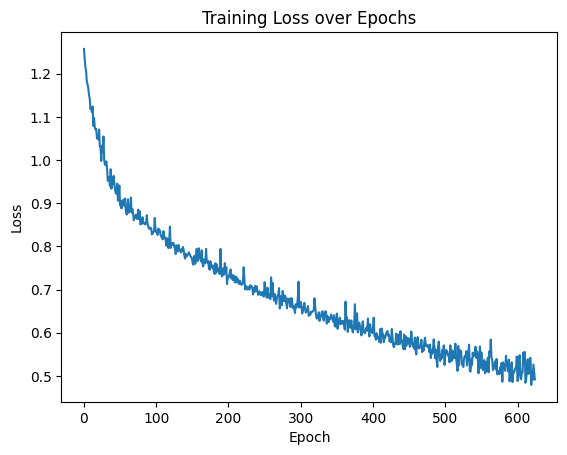

In [27]:
plt.plot(loss_list,label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

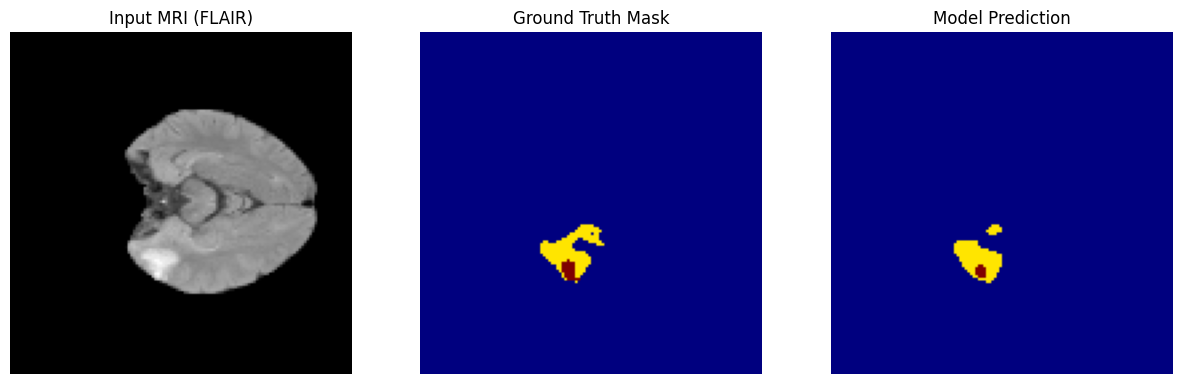

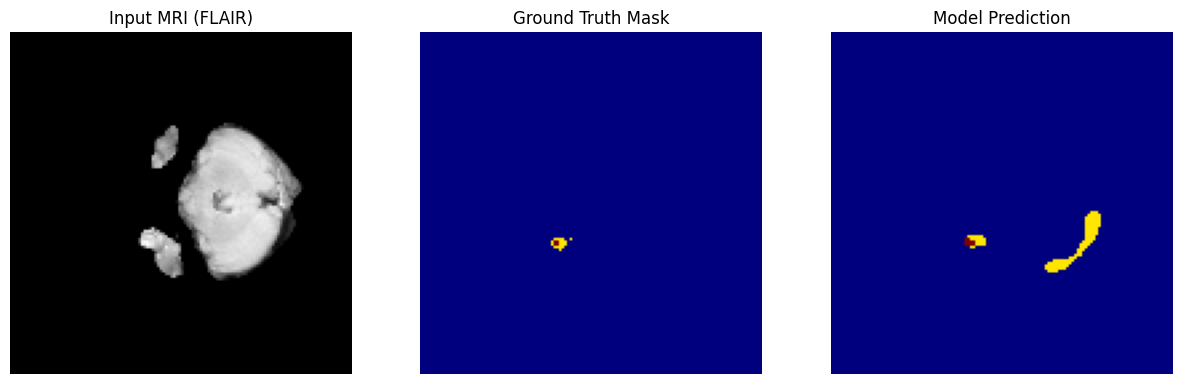

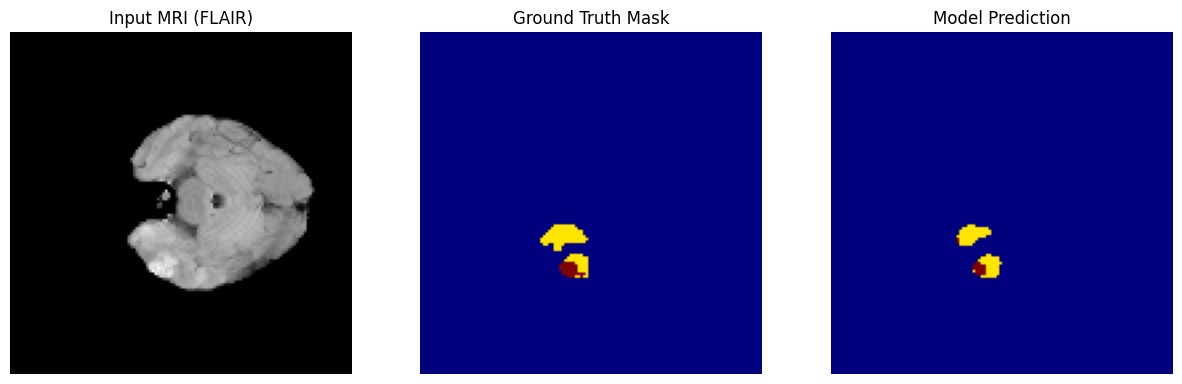

In [28]:
model_test=UNet().to(device)

model_path="/content/unet_brats_epoch_5_new.pth"
model_test.load_state_dict(torch.load(model_path,map_location=device))

model_test.eval()
for i in range(3):
  images,masks=next(iter(test_loader))
  with torch.no_grad():
      images=images.to(device)
      masks=masks.to(device)

      outputs=model_test(images)
      preds=torch.argmax(outputs,dim=1)

  def plot_prediction(img_tensor,true_mask,pred_mask,slice_idx=0):

      img=img_tensor.cpu().numpy()
      true=true_mask.cpu().numpy()
      pred=pred_mask.cpu().numpy()

      flair_img=img[0]

      fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

      ax1.imshow(flair_img,cmap='gray')
      ax1.set_title("Input MRI (FLAIR)")
      ax1.axis('off')

      ax2.imshow(true,cmap='jet',vmin=0,vmax=3)
      ax2.set_title("Ground Truth Mask")
      ax2.axis('off')

      ax3.imshow(pred,cmap='jet',vmin=0,vmax=3)
      ax3.set_title("Model Prediction")
      ax3.axis('off')

      plt.show()

  plot_prediction(images[2],masks[2],preds[2])

In [ ]:
def final_metrics(model,test_loader,device,num_classes=4):

    model.eval()

    total_intersection=torch.zeros(num_classes).to(device)
    total_union_iou=torch.zeros(num_classes).to(device)
    total_union_dice=torch.zeros(num_classes).to(device)

    with torch.no_grad():
        for images,masks in test_loader:
            images,masks=images.to(device),masks.to(device)

            logits=model(images)
            preds=torch.argmax(logits,dim=1)

            preds_oh=F.one_hot(preds,num_classes).permute(0,3,1,2).float()
            masks_oh=F.one_hot(masks,num_classes).permute(0,3,1,2).float()

            intersection=(preds_oh*masks_oh).sum(dim=(0,2,3))

            union_iou=(preds_oh+masks_oh).sum(dim=(0,2,3))-intersection

            union_dice=preds_oh.sum(dim=(0,2,3))+masks_oh.sum(dim=(0,2,3))

            total_intersection+=intersection
            total_union_iou+=union_iou
            total_union_dice+=union_dice

    smooth=1e-6

    tot_iou=(total_intersection+smooth)/(total_union_iou+smooth)
    tot_dice=(2.*total_intersection+smooth)/(total_union_dice+smooth)

    iou_list=tot_iou.cpu().numpy()
    dice_list=tot_dice.cpu().numpy()
    print(f"Mean IoU: {tot_iou.mean().item()}")
    print(f"Mean Dice: {tot_dice.mean().item()}")


final_metrics(model_test,test_loader,device,4)

Mean IoU: 0.5180877447128296
Mean Dice: 0.6234368681907654
